## RL algorithms
<!-- video shot="/RReyhShw_Wk" start="00:36" end="11:46" -->

In [2]:
# HIDDEN
import gym
import time
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams["font.size"] = 14

In [3]:
# HIDDEN
import ray
import logging
ray.init(log_to_driver=False, ignore_reinit_error=True, logging_level=logging.ERROR) # logging.FATAL

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

#### RL algorithms

- We used the PPO algorithm for almost the entire course (except offline RL)
- In fact, RLlib offers many algorithms! See [here](https://docs.ray.io/en/latest/rllib/rllib-algorithms.html).
- Let's look at one more algorithm, DQN.

Notes:

There are over 20 algorithms at the time of recording.

#### Deep Q-Network (DQN)

- DQN is famous in the RL world for many breakthroughs such as the [Atari results](https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf) from 2013.
- In RLlib, we only need to make the smallest of swaps:

PPO:

In [4]:
from ray.rllib.algorithms.ppo import PPOConfig

ppo = PPOConfig().framework("torch").debugging(log_level="ERROR").build(env="FrozenLake-v1")

DQN:

In [5]:
from ray.rllib.algorithms.dqn import DQNConfig

dqn = DQNConfig().framework("torch").debugging(log_level="ERROR").build(env="FrozenLake-v1")

And that's it!

#### PPO vs. DQN on Frozen Lake

In [6]:
t = time.time()
ppo_results = []
for i in range(50):
    ppo_results.append( ppo.train()["episode_reward_mean"] )
print(f"Elapsed time {time.time()-t:.1f} s")

Elapsed time 149.3 s


In [7]:
t = time.time()
dqn_results = []
for i in range(50):
    dqn_results.append( dqn.train()["episode_reward_mean"] )
print(f"Elapsed time {time.time()-t:.1f} s")

Elapsed time 118.1 s


#### PPO vs. DQN on Frozen Lake

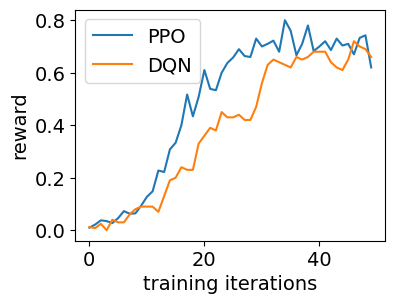

In [8]:
plt.figure(figsize=(4,3))
plt.plot(ppo_results, label="PPO")
plt.plot(dqn_results, label="DQN")
plt.legend()
plt.xlabel("training iterations")
plt.ylabel("reward");

- In this particular run of this case, the two algorithms seem to do about equally well.
- But, in general, one may be more suitable than the other.

Notes:

As in supervised learning, if you don't have domain expertise, an empirical approach is practical: try a few algorithms. PPO is a workhorse of RL, similar to something like a random forest or XGBoost in SL. That is why we focused on it in this course.

#### On-policy vs. off-policy

- Under the hood PPO and DQN work very differently
- PPO is an **on-policy** algorithm, DQN is **off-policy**
- This makes DQN more _sample efficient_ than PPO.
- They also have similarities, e.g. both are _model-free_ methods

Notes:

- PPO trains while running its own policy
- DQN can train on _experiences_ that may come from another policy (related to offline RL)
- DQN learns like offline RL (from data) but it continuously generates new data from the env
- Because DQN can learn from experiences, it can save up experiences and reuse them, meaning it can use the simulator less. This makes it more sample efficient. PPO is less sample efficient; by being on-policy it needs to be generating new data all the time to update the policy.

#### Q-values

- One big difference is that DQN directly learns _Q-values_
- For each state-action pair, a Q-value is a measure of "goodness" of taking that action.
- Let's take a look:

In [9]:
# HIDDEN
import utils

In [10]:
env = gym.make("FrozenLake-v1")
dqn.compute_single_action(3, full_fetch=True)[2]["q_values"]

array([0.23526135, 0.15835115, 0.15222909, 0.29895064], dtype=float32)

Notes:

- The interpretation is _somewhat_ similar to the action probabilities we saw with PPO, but these values are _not_ probabilities.
- The largest Q-value is for action=3 (up). This is consistent with what we saw in Module 2, where we saw the agent tries to move up towards the edge of the map in this situation (using PPO in that case).

#### Q-values

Here are the Q-values for all 16 possible observations:

In [11]:
q_sa = np.array([dqn.compute_single_action(i, full_fetch=True)[2]["q_values"] for i in range(16)])
q_sa

array([[0.40441144, 0.37283966, 0.37516856, 0.36622766],
       [0.25942954, 0.21730447, 0.21002412, 0.37577847],
       [0.3007025 , 0.2856053 , 0.28061193, 0.29295456],
       [0.23526135, 0.15835115, 0.15222909, 0.29895064],
       [0.4312221 , 0.2704375 , 0.2654389 , 0.2697962 ],
       [0.27185458, 0.2670835 , 0.29365933, 0.27747917],
       [0.26928356, 0.26565585, 0.2664524 , 0.14169857],
       [0.27213413, 0.191841  , 0.36448205, 0.21418208],
       [0.28224307, 0.27335888, 0.25944772, 0.47506106],
       [0.35679463, 0.55939525, 0.43025267, 0.25650108],
       [0.55461395, 0.39638543, 0.4024274 , 0.3626644 ],
       [0.25903583, 0.25135708, 0.34502658, 0.21859603],
       [0.26853585, 0.12316205, 0.20560387, 0.26153737],
       [0.36039925, 0.50105107, 0.6461959 , 0.35484454],
       [0.7016076 , 0.82596284, 0.7894067 , 0.6941653 ],
       [0.29056343, 0.03002909, 0.26235998, 0.2082822 ]], dtype=float32)

#### Q-values

We can plot these 64 (16x4) Q-values:

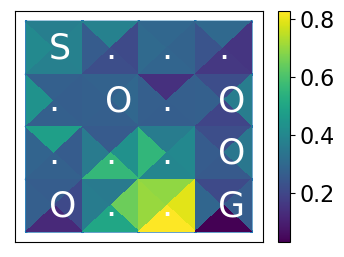

In [14]:
plt.figure(figsize=(4,3))
utils.q_state_action_plot_frozenlake(q_sa, env) # See GitHub for source code

We saw a similar plot in Module 2 with the PPO action probabilities.

Observations:

- We again see the desire to move up from the top-right.
- The strongest desire is to not die at square 10. Moving left is the only 100% safe move.
- Why move down at square 14? Because 13 is better than 10. More on that below!

#### State Q-values

There are also Q-values for each state, independent of actions. Let's turn out attention to these.

In [15]:
utils.get_q_state(dqn, env, 3)

0.21119806170463562

- Apparently the observation "3" (player at top-right) has a "value" of 0.21.
- The units of this "value" is expected discounted total reward.
  - Recall, we discussed discounting from Module 4!

(See [GitHub](https://github.com/anyscale/rl-course/blob/master/notebooks/utils.py) for `get_q_state` source code.)

With PPO, Q-values are not available.

In [1]:

# HIDDEN
# utils.get_q_state(ppo, env, 3)

Notes:

For Frozen Lake, all the values will be less than 1 because 1 is the maximum reward of an episode. Even if an agent is sure it will get to the end, the value will be less than 1 because of the discounting. 

Because of the discounting, we shouldn't interpret this value number as a probability of reaching the goal.

#### Q-values

We can look at these for all 16 observations using a plot:

In [18]:
q_s = [utils.get_q_state(dqn, env, i) for i in range(16)]

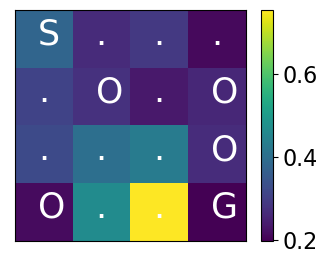

In [19]:
plt.figure(figsize=(4,3))
utils.q_state_plot_frozenlake(q_s, env) # See GitHub for the source code

- Let's loop back to what we saw in Module 2, that the agent wanted to move _down_ from location 14.
- Now we can see that state 10 (above 14) has a lower value than state 13 (left of 14).
- So, although PPO doesn't explicitly represent a value function for each state, this may be the "logic".

Notes:
    
Here we see that the most desirable state is the one before the goal. We can also see that the states have higher Q values as they get nearer the goal. Remember that this is the slippery Frozen Lake, so winning isn't guaranteed and being closer to the goal is indeed better.

The Q-values for the end states (O and G) don't look particularly meaningful. 

#### Back to PPO vs. DQN

- PPO uses the neural network to map from observations to action probabilities
- DQN uses the neural network to map from observations to Q-values

#### Continuous action spaces

- In this course we have used discrete and continuous _observation_ spaces, but only discrete _action_ spaces.
- Example of a continuous action space: what angle to set the steering wheel to in a car.
- PPO can still be used with a continuous action space: it learns a probability distribution over actions.
- DQN cannot be directly applied to a continuous action space. 

#### Beyond DQN

- There are many RL algorithms, and new ones are being invented every year!
- DQN: 2013, PPO: 2017, ...
- As with deep learning, RL as a field is moving fast.

#### Let's apply what we learned!

## PPO vs. DQN
<!-- multiple choice -->

Which is a better algorithm, PPO or DQN?

- [x] PPO is our recommended starting point for most problems, but DQN might be more suitable sometimes.
- [ ] DQN is our recommended starting point for most problems, but PPO might be more suitable sometimes.
- [ ] PPO is always a better choice than DQN.
- [ ] DQN is always a better choice than PPO.

## Switching algorithms in RLlib
<!-- multiple choice -->

How does one switch to a different RL algorithm in RLlib?

- [ ] In the config, change the `algo` parameter, e.g. `config.training(algo="DQN")
- [ ] Specify this when calling `.train()`, e.g. `algo.train("DQN")`
- [ ] Instantiate the base config for that algorithm, e.g. `DQNConfig()` instead of `PPOConfig()`
- [ ] To change RL algorithms, you need to switch to another package instead of RLlib

## Changing the RLlib algorithm
<!-- coding exercise -->

Complete the code below so that it trains an agent on the gym [Taxi-v3](https://www.gymlibrary.dev/environments/toy_text/taxi/) environment using both PPO and DQN for 10 iterations. Which algorithm appears to do better after 10 iterations of training?

(Note that, just because one algorithm does better in a small number of iterations, doesn't mean it will be better overall!)

In [30]:
# EXERCISE

import matplotlib.pyplot as plt
from ray.rllib.algorithms.ppo import PPOConfig
from ____ import ____

# suppress warnings
import ray
import logging
ray.init(log_to_driver=False, ignore_reinit_error=True, logging_level=logging.ERROR)
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

ppo_config = (
    PPOConfig()
    .framework("torch")
    .rollouts(create_env_on_local_worker=True)
    .debugging(seed=0, log_level="ERROR")
    .training(model={"fcnet_hiddens" : [32, 32]})
    .environment(env="Taxi-v3")
)

ppo = ppo_config.build()

ppo_rewards = []
for i in range(10):
    print(i)
    out = ppo.train()
    ppo_rewards.append(out["episode_reward_mean"])
    

dqn_config = (
    ____()
    .framework("torch")
    .rollouts(create_env_on_local_worker=True)
    .debugging(seed=0, log_level="ERROR")
    .training(model={"fcnet_hiddens" : [32, 32]})
    .environment(env="Taxi-v3")
)

dqn = dqn_config.build()

dqn_rewards = []
for i in range(10):
    print(i)
    out = ____.train()
    dqn_rewards.append(out["episode_reward_mean"])
    
plt.plot(ppo_rewards, label="PPO")
plt.plot(dqn_rewards, label="DQN")
plt.legend()
plt.xlabel("training iterations")
plt.ylabel("reward")

ppo.stop()
dqn.stop()

-274.7

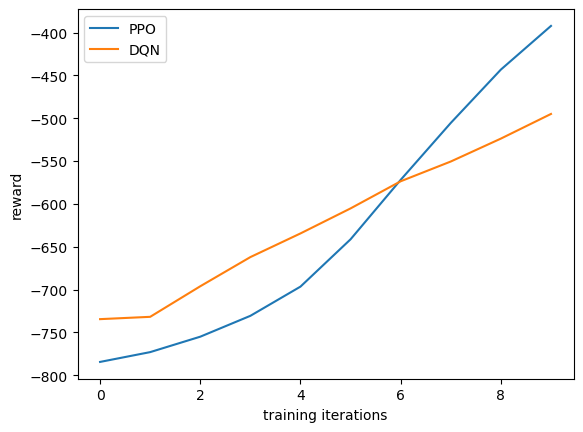

In [4]:
# SOLUTION

import numpy as np
import matplotlib.pyplot as plt
from ray.rllib.algorithms.ppo import PPOConfig
from ray.rllib.algorithms.dqn import DQNConfig

# suppress warnings
import ray
import logging
ray.init(log_to_driver=False, ignore_reinit_error=True, logging_level=logging.ERROR)
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

ppo_config = (
    PPOConfig()
    .framework("torch")
    .rollouts(create_env_on_local_worker=True)
    .debugging(seed=0, log_level="ERROR")
    .training(model={"fcnet_hiddens" : [32, 32]})
    .environment(env="Taxi-v3")
)

ppo = ppo_config.build()

ppo_rewards = []
for i in range(10):
    print(i)
    out = ppo.train()
    ppo_rewards.append(out["episode_reward_mean"])
    

dqn_config = (
    DQNConfig()
    .framework("torch")
    .rollouts(create_env_on_local_worker=True)
    .debugging(seed=0, log_level="ERROR")
    .training(model={"fcnet_hiddens" : [32, 32]})
    .environment(env="Taxi-v3")
)

dqn = dqn_config.build()

dqn_rewards = []
for i in range(10):
    print(i)
    out = dqn.train()
    dqn_rewards.append(out["episode_reward_mean"])
    
plt.plot(ppo_rewards, label="PPO")
plt.plot(dqn_rewards, label="DQN")
plt.legend()
plt.xlabel("training iterations")
plt.ylabel("reward")

ppo.stop()
dqn.stop()

#### Which algorithm performs better?

Which algorithm performs better after 10 iterations of training on the Taxi-v3 environment?

- [x] PPO achieves a higher reward
- [ ] DQN achieves a higher reward
- [ ] PPO and DQN achieve the same reward

In [5]:
## TODO
# Could try some new sort of env and see what the preprocessor does. CartPole not interesting because no preprocessing happens. 

## Q-values in CartPole
#<!-- coding exercise -->

#Look at the Q-values for different pole angles!

In [31]:
## TODO
# Could try some new sort of env and see what the preprocessor does. CartPole not interesting because no preprocessing happens. 

In [8]:
# TODO
# or could do Q values for Taxi
# or even the recommender environment, I guess?

In [ ]:
# TODO
## Changing the network architecture
# <!-- coding exercise -->
# change fcnet_hiddens and see what happens - we can see the size of the torch tensor being different. 

In [9]:
# HIDDEN
# import numpy as np
# import matplotlib.pyplot as plt

# cartpole_config = (
#     PPOConfig()
#     .framework("torch")
#     .rollouts(create_env_on_local_worker=True)
#     .debugging(seed=0, log_level="ERROR")
#     .training(model={"fcnet_hiddens" : [256, 256]})
#     .environment()
# )

# algo = cartpole_config.build(env="FrozenLake-v1")

# for i in range(5):
#     algo.train()

# plt.plot(results)